In [1]:
%matplotlib inline
import cv2
import numpy as np
from image_pipeline import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
import pickle
import os
import math
from scipy.ndimage.measurements import label

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score
import time
from sklearn.model_selection import train_test_split

from image_pipeline import Operation, Color, Sobel, Magnitude, Direction, \
  Threshold, Combinator, FindLinesSlidingWindows, Annotate, ImagePipeline

# Lane Finder + Vehicle Detection

## 1. Preparation

In [2]:
ip = ImagePipeline(input_color='bgr')
ip.calibrate(glob.glob('camera_cal/calibration*.jpg'))
mtx = ip.mtx
dist = ip.dist

In [3]:
# Read in cars and notcars
images = glob.glob('training_data/vehicles/*/*.png')
cars = []
for image in images:
    cars.append(image)
images = glob.glob('training_data/non-vehicles/*/*.png')
notcars = []
for image in images:
    notcars.append(image)

sample_size = 10000
random_idx = np.random.randint(0, len(cars), min(len(cars),sample_size))
cars = np.array(cars)[random_idx]
notcars = np.array(notcars)[random_idx]
print("Number of cars: {}\nNumber of non-cars: {}".format(len(cars), len(notcars)))

Number of cars: 8792
Number of non-cars: 8792


## 2. Training the dataset

In [4]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec,
                                  block_norm='L2-Hys')
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec,
                       block_norm='L2-Hys')
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features
# Tried using only the saturation without avail
#     channel1_hist = np.histogram(cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2], bins=nbins)
#     return channel1_hist[0]


# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True,
                        vis=False):
    #1) Define an empty list to receive features
    img_features = []
    img_hogs = []
    
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            if vis == True:
                hog_images = []
                for channel in range(feature_image.shape[2]):
                    hf, hi = get_hog_features(feature_image[:,:,channel], 
                                              orient, pix_per_cell, cell_per_block, 
                                              vis=True, feature_vec=True)
                    hog_features.extend(hf)
                    hog_images.extend(hi)
            else:
                for channel in range(feature_image.shape[2]):
                    hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
#             print("chs: {}, orient: {}, pix_per_cell: {}, cell_per_block: {}".format(feature_image.shape[2], orient,
#                                                                                      pix_per_cell, cell_per_block))
        else:
            if vis == True:
                hog_features, hog_images = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
        try:
            img_hogs.append(hog_images)
        except:
            pass
    
#     print(spatial_features.shape)
#     print(hist_features.shape)
#     print(len(hog_features))
#     print(np.concatenate(img_features).shape)
    #9) Return array of features
    if vis == True:
        return (np.concatenate(img_features), img_hogs)
    else:
        return np.concatenate(img_features)

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        file_features = single_img_features(image, color_space=color_space, spatial_size=spatial_size,
                                            hist_bins=hist_bins, orient=orient, 
                                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                            spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=False)
        features.append(file_features)
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [13]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
cells_per_step = 1

In [6]:
CLF_PICKLE = 'clf.pickle'
if os.path.isfile(CLF_PICKLE):
    clf = pickle.load(open(CLF_PICKLE, "rb"))
    X_scaler = clf['X_scaler']
    svc = clf['svc']
    print("classifier and scaler loaded")
else:
    print("Extracting features...")
    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    t = time.time()
    print("Fitting scaler...")
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    
    clf = GridSearchCV(svc, {'C':[0.1, 1, 0.6]},
                       scoring='precision', n_jobs=2)
    clf.fit(X_train, y_train)
    svc = clf.best_estimator_
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    y_pred = svc.predict(X_test)
    print('Test Precision of SVC = ', precision_score(y_test, y_pred))

    clf_dict = {
        'svc': svc,
        'X_scaler': X_scaler
    }
    
    pickle.dump(clf_dict, open(CLF_PICKLE, "wb"))
    
print(svc)

classifier and scaler loaded
LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


## 3. Setup pipeline

In [48]:
class AnnotateLines(Operation):
    def __init__(self, line_finder_obj):
        self.type = TYPE_LINEAR
        self.line_finder_obj = line_finder_obj
        self.map = None
    
    def process(self, updated_img):
        img = updated_img
        warped = np.copy(self.ip.warped_img)
        undist = np.copy(self.ip.undist_img)
        f = self.line_finder_obj
        left_fitx = f.left_fitx
        right_fitx = f.right_fitx
        ploty = f.ploty
        Minv = self.ip.Minv
        margin = f.subsequent_search_margin

        # Create an image to draw the lines on
        color_warp = np.zeros_like(warped).astype(np.uint8)

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))], np.int32)
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        cv2.polylines(color_warp, np.int_([pts_left]), False, (255, 0, 0), thickness=20)
        cv2.polylines(color_warp, np.int_([pts_right]), False, (0, 0, 255), thickness=20)
        
        text0 = "Curvature radius:"
        text = "left: {:.2f}m, right: {:.2f}m".format(f.left_curverad_m, f.right_curverad_m)
        text1 = "Distance from center: {:.2f}m".format(f.distance_to_center_m)
        cv2.putText(undist, text0, (40, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), thickness=2)
        cv2.putText(undist, text, (40, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), thickness=2)
        cv2.putText(undist, text1, (40, 160), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), thickness=2)

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
        
        # Add a small map section 
        minimap = f.img
        nonzero = minimap.nonzero()
        nonzeroy = nonzero[0]
        nonzerox = nonzero[1]
        left_lane_inds = f.left_lane_inds
        right_lane_inds = f.right_lane_inds
        
        # Color in left and right line pixels
        minimap = (np.dstack((minimap, minimap, minimap))*255).astype(np.uint8)
        if not(left_lane_inds.shape[0] == 0 or right_lane_inds.shape[0] == 0):
            minimap[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 255, 0]
            minimap[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 255, 255]
        
        if len(f.windows) > 0:
            for w in f.windows:
                cv2.rectangle(minimap,(w['win_xleft_low'],w['win_y_low']),(w['win_xleft_high'],w['win_y_high']),(0,255,0), 2) 
                cv2.rectangle(minimap,(w['win_xright_low'],w['win_y_low']),(w['win_xright_high'],w['win_y_high']),(0,255,0), 2)
        else:
            left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
            left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
            left_line_pts = np.hstack((left_line_window1, left_line_window2))
            right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
            right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
            right_line_pts = np.hstack((right_line_window1, right_line_window2))

            # Draw the lane onto the minimap
            window_img = np.zeros_like(minimap)
            cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
            cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
            minimap = cv2.addWeighted(minimap, 1, window_img, 0.3, 0)

        cv2.polylines(minimap, np.int_([pts_left]), False, (255, 0, 0), thickness=10)
        cv2.polylines(minimap, np.int_([pts_right]), False, (0, 0, 255), thickness=10)
        
        self.map = np.copy(minimap)
        
        minimap = cv2.resize(minimap,(int(0.3*minimap.shape[1]), int(0.3*minimap.shape[0])), interpolation = cv2.INTER_CUBIC)
        
        x_offset=850
        y_offset=50
        result[y_offset:y_offset+minimap.shape[0], x_offset:x_offset+minimap.shape[1]] = minimap
        return result
    
class AnnotateObjects(Operation):
    def __init__(self, model, X_scaler, n_threshold=3, ystart=400, ystop=645, scales=[1.5, 2, 3],
                 color_space = 'YCrCb',
                 orient = 12,
                 pix_per_cell = 16,
                 cell_per_block = 2,
                 hog_channel = 'ALL',
                 spatial_size = (16, 16),
                 hist_bins = 16,
                 spatial_feat = True,
                 hist_feat = True,
                 hog_feat = True,
                 cells_per_step = 1,
                 img_type='png'
                ):
        self.type = TYPE_LINEAR
        self.bbox_list = [[],[]]
        self.bbox_all = []
        self.frame_counter = 0

        self.model = model
        self.X_scaler = X_scaler
        
        self.n_threshold = n_threshold
        self.ystart = ystart
        self.ystop = ystop
        self.scales = scales

        self.color_space = color_space # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        self.orient = orient  # HOG orientations
        self.pix_per_cell = pix_per_cell # HOG pixels per cell
        self.cell_per_block = cell_per_block # HOG cells per block
        self.hog_channel = hog_channel # Can be 0, 1, 2, or "ALL"
        self.spatial_size = spatial_size # Spatial binning dimensions
        self.hist_bins = hist_bins    # Number of histogram bins
        self.spatial_feat = spatial_feat # Spatial features on or off
        self.hist_feat = hist_feat # Histogram features on or off
        self.hog_feat = hog_feat # HOG features on or off
        self.cells_per_step = cells_per_step
        self.img_type = img_type
        


    def process(self, updated_img):
        """
        Process every x frames
        """
        bbox_list = self.bbox_list
        n_threshold = self.n_threshold
        frame_counter = self.frame_counter
        bbox_all = self.bbox_all
    
        copy_img = np.copy(self.ip.undist_img)

        if frame_counter % 2 == 0:
            idx = 1
        else:
            idx = 0
        bbox_list[idx] = []
        for scale in self.scales:
            _, bbox_list[idx] = self.find_cars(copy_img, self.ystart, self.ystop, scale, self.model, self.X_scaler, self.orient,
                                     self.pix_per_cell, self.cell_per_block, self.spatial_size, self.hist_bins, img_type=self.img_type,
                                     hog_channel=self.hog_channel, bbox_list=bbox_list[idx], color_space=self.color_space,
                                     cells_per_step=self.cells_per_step)
        bbox_all.extend(bbox_list[idx])
    
        heat = np.zeros_like(copy_img[:,:,0]).astype(np.float)
        heat = self.add_heat(heat,bbox_list[0] + bbox_list[1])

        # Apply threshold to help remove false positives
        heat = self.apply_threshold(heat, n_threshold)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)

        # Draw bounding boxes on a copy of the image
        draw_img = self.draw_labeled_bboxes(updated_img, labels)

        frame_counter += 1

        return draw_img
    
    def add_heat(self, heatmap, bbox_list):
        # Iterate through list of bboxes
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

        # Return updated heatmap
        return heatmap# Iterate through list of bboxes

    def apply_threshold(self, heatmap, threshold):
        # Zero out pixels below the threshold
        heatmap[heatmap <= threshold] = 0
        # Return thresholded map
        return heatmap

    def draw_labeled_bboxes(self, img, labels, return_bbox_list=False):
        bbox_list = []
        for bbox in self.bboxes_from_labels(labels):
            bbox_list.append(bbox)
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        if return_bbox_list:
            return (img, bbox_list)
        else:
            # Return the image
            return img

    def bboxes_from_labels(self, labels):
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            yield(bbox)
    
    # Define a single function that can extract features using hog sub-sampling and make predictions
    def find_cars(self, img, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell,
                  cell_per_block, spatial_size, hist_bins, img_type='png',
                  hog_channel=1, bbox_list=None, color_space='YUV', cells_per_step=1):        

        draw_img = np.copy(img)
        if bbox_list is None:
            bbox_list = []
        else:
            for bbox in bbox_list:
                cv2.rectangle(draw_img,*bbox,(0,0,255),6) 

        if img_type in ('png'):
            img = img.astype(np.float32)/255
        elif img_type in ('jpg', 'jpeg'):
            pass
        img_tosearch = img[ystart:ystop,:,:]

        if color_space != 'RGB':
            if color_space == 'HSV':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
        else: ctrans_tosearch = np.copy(img_tosearch)

        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        chs = [
            ctrans_tosearch[:,:,0],
            ctrans_tosearch[:,:,1],
            ctrans_tosearch[:,:,2]
        ]

        # Define blocks and steps as above
        nxblocks = (chs[0].shape[1] // pix_per_cell)-1
        nyblocks = (chs[0].shape[0] // pix_per_cell)-1 
        nfeat_per_block = orient*cell_per_block**2
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell)-1 
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hogs = []
        for i in range(3):
            if hog_channel == i or hog_channel == 'ALL':
                hog_f = get_hog_features(chs[i], orient, pix_per_cell, cell_per_block, feature_vec=False, vis=False)
                hogs.append(hog_f)
    #     print("chs: {} orient: {} pix_per_cell: {}, cell_per_block: {}".format(len(chs), orient, pix_per_cell, cell_per_block))
        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feats = []
                for i in range(len(hogs)):
                    hog_feats.append(hogs[i][ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel())
                hog_features = np.hstack(hog_feats)

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                train_img_width_px = 64
                train_img_height_px = 64
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (train_img_width_px,train_img_height_px))

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)


                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                test_prediction = clf.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    bbox = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                    bbox_list.append(bbox)
                    cv2.rectangle(draw_img,*bbox,(0,0,255),6) 

        return (draw_img, bbox_list)
    
    # Define a function you will pass an image 
    # and the list of windows to be searched (output of slide_windows())
    def search_windows(self, img, windows, clf, scaler, color_space='RGB', 
                        spatial_size=(32, 32), hist_bins=32, 
                        hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, 
                        hog_channel=0, spatial_feat=True, 
                        hist_feat=True, hog_feat=True):

        #1) Create an empty list to receive positive detection windows
        on_windows = []
        #2) Iterate over all windows in the list
        for window in windows:
            #3) Extract the test window from original image
            test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
            #4) Extract features for that window using single_img_features()
            features = single_img_features(test_img, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
            #5) Scale extracted features to be fed to classifier
            test_features = scaler.transform(np.array(features).reshape(1, -1))
            #6) Predict using your classifier
            prediction = clf.predict(test_features)
            #7) If positive (prediction == 1) then save the window
            if prediction == 1:
                on_windows.append(window)
        #8) Return windows for positive detections
        return on_windows

In [49]:
ip_vid = ImagePipeline(input_color='rgb')

src = np.float32([[  100.,   720.],
                  [  542.,   470.],
                  [  738.,   470.],
                  [ 1180.,   720.]])

# Choose x positions that allow for 3.7m for the lane position closest to car.
dst = np.float32([[ 225.,  720.],
                  [ 225.,    0.],
                  [ 1055.,    0.],
                  [ 1055.,  720.]])

ip_vid.set_perspective(src, dst)

ip_vid.mtx = mtx
ip_vid.dist = dist

t1 = Threshold(trange=(1, 255), crop_b=50)
t1.add(Color(['h', 'l', 's'], in_range=((20, 100, 12), (138, 255, 255))))
ip_vid.add(t1)

t2 = Threshold(trange=(1, 255), crop_b=50)
t2.add(Color(['h', 'l', 's'], in_range=((0, 202, 0), (255, 255, 255))))
ip_vid.add(t2)

t3 = Threshold(trange=(4, 161), crop_b=50)
t3.add(Color(['s']))
t3.add(Sobel('y', kernel=15))
t3.add(Magnitude())
ip_vid.add(t3)


c = Combinator(f=(lambda ths: np.where(((ths[0] == 1) | (ths[1] == 1)) & (ths[2] == 1))))
ip_vid.add(c)
f = FindLinesSlidingWindows(always_recalculate=False)
ip_vid.add(f)

an = AnnotateLines(f)
ip_vid.add(an)

X_scaler = clf['X_scaler']
svc = clf['svc']

obj = AnnotateObjects(svc, X_scaler,
                      color_space=color_space,
                      orient=orient,
                      pix_per_cell=pix_per_cell,
                      cell_per_block=cell_per_block,
                      hog_channel=hog_channel,
                      spatial_size=spatial_size,
                      hist_bins=hist_bins,
                      spatial_feat=spatial_feat,
                      hist_feat=hist_feat,
                      hog_feat=hog_feat,
                      cells_per_step = cells_per_step,
                      img_type='jpg')
ip_vid.add(obj)

## 4. Single Image

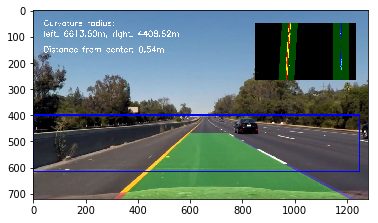

In [51]:
image_path = 'test_images/test9.jpg'
img = cv2.imread(image_path)
img = cv2.resize(img, (1280, 720))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(ip_vid.process(img))

# 3. Video

In [52]:
ip_vid.operations[-1].img_type = 'png'

In [54]:
from moviepy.editor import VideoFileClip

bbox_list = [[],[]]
bbox_all = []
frame_counter = 0
test_output = 'test_video_processed.mp4'
clip = VideoFileClip('test_video.mp4')
test_clip = clip.fl_image(ip_vid.process)
test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video test_video_processed.mp4
[MoviePy] Writing video test_video_processed.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:25<00:00,  1.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_processed.mp4 



In [56]:
bbox_list = [[],[]]
bbox_all = []
frame_counter = 0
test_output = 'project_video_processed.mp4'
clip = VideoFileClip('project_video.mp4')
test_clip = clip.fl_image(ip_vid.process)
test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video project_video_processed.mp4
[MoviePy] Writing video project_video_processed.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [14:44<00:00,  1.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_processed.mp4 

